# Evaluating GNN and CGNN
This is a notebook to evaluate the implementation of GNN and CGNN from the paper [Learning Functional Causal Models with Generative Neural Networks](https://arxiv.org/abs/1709.05321). The following is an implementation of an extended version of the first experiement mentioned in the paper.

In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import why

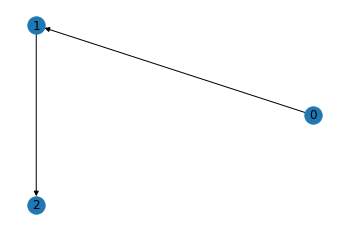

In [34]:
# Generate a synthetic dataset
n_nodes = 3
n_samples = 500

graph = nx.DiGraph()

graph.add_nodes_from(range(n_nodes))

data = np.zeros((n_samples, n_nodes))
data[:, 0] = np.random.uniform(-2, 2, n_samples)
for i in range(1, n_nodes):
    data[:, i] = data[:, i - 1] + np.random.uniform(0, 0.5, n_samples)
    graph.add_edge(i - 1, i)

unsolved_graph = copy.deepcopy(graph)
for edge in graph.edges():
    unsolved_graph.add_edge(edge[1], edge[0])

data = pd.DataFrame(data, columns=[i for i in range(n_nodes)])
plt.plot("Ground Truth")
nx.draw_circular(graph, with_labels=True)

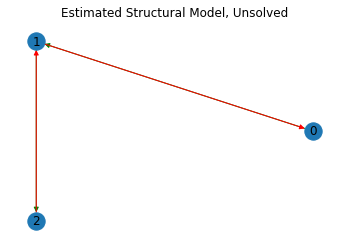

50.0

In [35]:
def evaluate(graph, gt_graph, method=""):
    colors = []
    count = 0
    for edge in graph.edges():
        if edge in gt_graph.edges():
            colors.append("green")
            count += 1
        else:
            colors.append("red")

    acc = (100*count/len(graph.edges()))
    plt.title("Estimated Structural Model, " + method)
    nx.draw_circular(graph, edge_color=colors, with_labels=True)
    plt.show()
    return acc
evaluate(unsolved_graph, graph, "Unsolved")

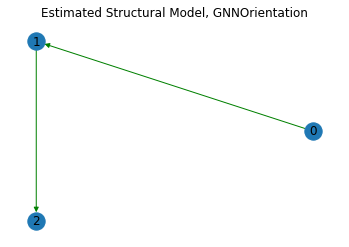

100.0

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gnn = why.GNNOrientation(n_train_runs=500, n_eval_runs=200, n_orientation_runs=16)
gnngraph = gnn.orient_edges(unsolved_graph, data, device)
evaluate(gnngraph, graph, "GNNOrientation")

In [37]:
incorrect_graph = nx.DiGraph()
incorrect_graph.add_nodes_from(range(n_nodes))
incorrect_graph.add_edge(2, 1)
incorrect_graph.add_edge(1, 0)

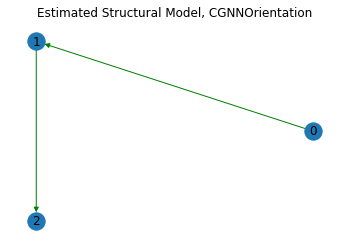

100.0

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cgnn = why.CGNNOrientation(n_train_runs=1000, n_eval_runs=400, n_orientation_runs=16)
cgnngraph = cgnn.optimize_graph(incorrect_graph, torch.from_numpy(data.values).float().to(device), device)
evaluate(cgnngraph, graph, "CGNNOrientation")